# RAMP on predicting cyclist traffic in Paris

Authors: *Roman Yurchak (Symerio)*; also partially inspired by the air_passengers starting kit.


## Introduction

The dataset was collected with cyclist counters installed by Paris city council in multiple locations. It contains hourly information about cyclist traffic, as well as the following features,
 - counter name
 - counter site name
 - date
 - counter installation date
 - latitude and longitude
 
Available features are quite scarce. However, **we can also use any external data that can help us to predict the target variable.** 

In [116]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
import xgboost as xgb


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid

import matplotlib.dates as mdates

from pandas_profiling import ProfileReport

# Loading the data with pandas

First, download the data files,
 - [train.parquet](https://github.com/rth/bike_counters/releases/download/v0.1.0/train.parquet)
 - [test.parquet](https://github.com/rth/bike_counters/releases/download/v0.1.0/test.parquet)

and put them to into the data folder.


Data is stored in [Parquet format](https://parquet.apache.org/), an efficient columnar data format. We can load the train set with pandas,

In [117]:
counters_train = pd.read_parquet(Path("data") / "train.parquet")

In [118]:
counters_test = pd.read_parquet(Path("data") / "test.parquet")

In [119]:
counters_train.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585


In [120]:
counters_train.columns

Index(['counter_id', 'counter_name', 'site_id', 'site_name', 'bike_count',
       'date', 'counter_installation_date', 'coordinates',
       'counter_technical_id', 'latitude', 'longitude', 'log_bike_count'],
      dtype='object')

In [121]:
counters_train.drop(columns=counters_train.columns
                    .difference(['date','site_name','counter_name','bike_count',
                                 'counter_installation_date','log_bike_count']),
                    inplace=True)

In [122]:
counters_train

,counter_name,site_name,bike_count,date,counter_installation_date,log_bike_count
48321,28 boulevard Diderot E-O,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,0.000000
48324,28 boulevard Diderot E-O,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,0.693147
48327,28 boulevard Diderot E-O,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,0.000000
48330,28 boulevard Diderot E-O,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,1.609438
48333,28 boulevard Diderot E-O,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,2.302585
...,...,...,...,...,...,...
928450,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,51.0,2021-08-08 18:00:00,2020-11-29,3.951244
928453,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,1.0,2021-08-09 02:00:00,2020-11-29,0.693147
928456,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,61.0,2021-08-09 08:00:00,2020-11-29,4.127134
928459,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,44.0,2021-08-09 10:00:00,2020-11-29,3.806662


# Adding Ext

In [123]:
ext = pd.read_csv('ext_data/ext_intense16.csv')
ext.drop('Unnamed: 0', axis=1,inplace=True)
ext["date"] = pd.to_datetime(ext["date"], format = "%Y/%m/%d %H:%M")
ext

,date,conf,ww_mix,pmer,ff,t,u,vv,ww,nbas,...,etat_sol,rr1,rr3,hourly,Intensev1,Intensev2,vacances_zone_c,bank_days,strike_rate,Vehicules
0,2020-09-01 00:00:00,0,1.0,102050,1.6,12.6,81,30000,1,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0.0,81.338753
1,2020-09-01 01:00:00,0,0.0,102050,1.6,12.6,81,30000,1,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0.0,81.338753
2,2020-09-01 02:00:00,0,0.0,102050,1.6,12.6,81,30000,1,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0.0,81.338753
3,2020-09-01 03:00:00,0,2.0,101990,1.1,10.8,88,25000,2,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0.0,81.338753
4,2020-09-01 04:00:00,0,0.0,101990,1.1,10.8,88,25000,2,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0.0,81.338753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9884,2021-10-17 20:00:00,0,0.0,102050,2.2,12.5,68,25000,3,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0.0,66.418217
9885,2021-10-17 21:00:00,0,1.0,102120,1.1,9.6,82,25000,1,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0.0,66.418217
9886,2021-10-17 22:00:00,0,0.0,102120,1.1,9.6,82,25000,1,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0.0,66.418217
9887,2021-10-17 23:00:00,0,0.0,102120,1.1,9.6,82,25000,1,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0.0,66.418217


In [124]:
train = pd.merge_asof(
        counters_train.sort_values('date'), ext.sort_values('date'), on="date"
    )

In [125]:
train.head()

,counter_name,site_name,bike_count,date,counter_installation_date,log_bike_count,conf,ww_mix,pmer,ff,...,etat_sol,rr1,rr3,hourly,Intensev1,Intensev2,vacances_zone_c,bank_days,strike_rate,Vehicules
0,Pont de Bercy SO-NE,Pont de Bercy,0.0,2020-09-01 01:00:00,2019-12-11,0.000000,0,0.0,102050,1.6,...,0.0,0.0,0.0,0,0,0,0,0,0.0,81.338753
1,6 rue Julia Bartet NE-SO,6 rue Julia Bartet,4.0,2020-09-01 01:00:00,2018-11-28,1.609438,0,0.0,102050,1.6,...,0.0,0.0,0.0,0,0,0,0,0,0.0,81.338753
2,6 rue Julia Bartet SO-NE,6 rue Julia Bartet,2.0,2020-09-01 01:00:00,2018-11-28,1.098612,0,0.0,102050,1.6,...,0.0,0.0,0.0,0,0,0,0,0,0.0,81.338753
3,Totem Cours la Reine O-E,Totem Cours la Reine,0.0,2020-09-01 01:00:00,2020-02-11,0.000000,0,0.0,102050,1.6,...,0.0,0.0,0.0,0,0,0,0,0,0.0,81.338753
4,Face au 25 quai de l'Oise NE-SO,Face au 25 quai de l'Oise,2.0,2020-09-01 01:00:00,2018-11-28,1.098612,0,0.0,102050,1.6,...,0.0,0.0,0.0,0,0,0,0,0,0.0,81.338753


We can check general information about different columns,

In [126]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455163 entries, 0 to 455162
Data columns (total 27 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_name               455163 non-null  category      
 1   site_name                  455163 non-null  category      
 2   bike_count                 455163 non-null  float64       
 3   date                       455163 non-null  datetime64[ns]
 4   counter_installation_date  455163 non-null  datetime64[ns]
 5   log_bike_count             455163 non-null  float64       
 6   conf                       455163 non-null  int64         
 7   ww_mix                     455163 non-null  float64       
 8   pmer                       455163 non-null  int64         
 9   ff                         455163 non-null  float64       
 10  t                          455163 non-null  float64       
 11  u                          455163 non-null  int64   

and in particular the number of unique entries in each column,

In [127]:
train.nunique(axis=0)

counter_name                   56
site_name                      30
bike_count                    977
date                         8230
counter_installation_date      22
log_bike_count                977
conf                            2
ww_mix                         48
pmer                          461
ff                            106
t                             336
u                              77
vv                           1061
ww                             42
nbas                           10
pres                          458
raf10                         168
etat_sol                        9
rr1                            31
rr3                            58
hourly                          2
Intensev1                       6
Intensev2                       6
vacances_zone_c                 2
bank_days                       2
strike_rate                     6
Vehicules                     342
dtype: int64

We have a 30 counting sites where sometimes multiple counters are installed per location.  Let's look at the most frequented stations,

In [128]:
train.groupby(["site_name", "counter_name"])["bike_count"].sum().sort_values(
    ascending=False
).head(25).to_frame()

,,bike_count
site_name,counter_name,
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol S-N,1809231.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli O-E,1406900.0
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol N-S,1357868.0
67 boulevard Voltaire SE-NO,67 boulevard Voltaire SE-NO,1036575.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli E-O,914089.0
27 quai de la Tournelle,27 quai de la Tournelle SE-NO,888717.0
Quai d'Orsay,Quai d'Orsay E-O,849724.0
Totem Cours la Reine,Totem Cours la Reine O-E,806149.0
Face au 48 quai de la marne,Face au 48 quai de la marne SO-NE,806071.0


In [129]:
#train.profile_report()

In [130]:
#import folium
#
#m = folium.Map(location=train[["latitude", "longitude"]].mean(axis=0), zoom_start=13)
#
#for _, row in (
#    train[["counter_name", "latitude", "longitude"]]
#    .drop_duplicates("counter_name")
#    .iterrows()
#):
#    folium.Marker(
#        row[["latitude", "longitude"]].values.tolist(), popup=row["counter_name"]
#    ).add_to(m)
#
#m

Note that in this RAMP problem we consider only the 30 most frequented counting sites, to limit data size.


Next we will look into the temporal distribution of the most frequented bike counter. If we plot it directly we will not see much because there are half a million data points,

<AxesSubplot:xlabel='date'>

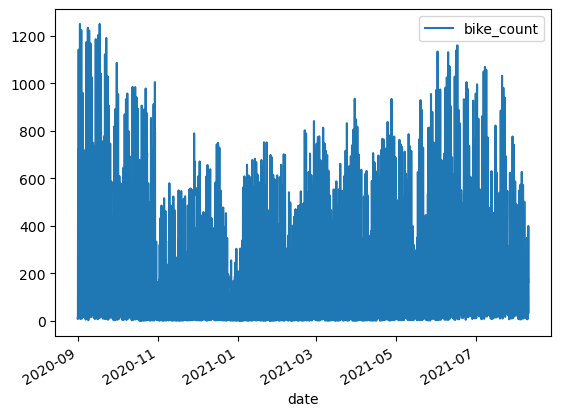

In [131]:
mask = train["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"

train[mask].plot(x="date", y="bike_count")

In [132]:
train[mask].groupby(pd.Grouper(freq="1w", key="date"))[["bike_count"]].sum()

,bike_count
date,
2020-09-06,49012.0
2020-09-13,61743.0
2020-09-20,61659.0
2020-09-27,50208.0
2020-10-04,43666.0
2020-10-11,45909.0
2020-10-18,47977.0
2020-10-25,39332.0
2020-11-01,30934.0


Instead we aggregate the data, for instance, by week to have a clearer overall picture,

<AxesSubplot:xlabel='date'>

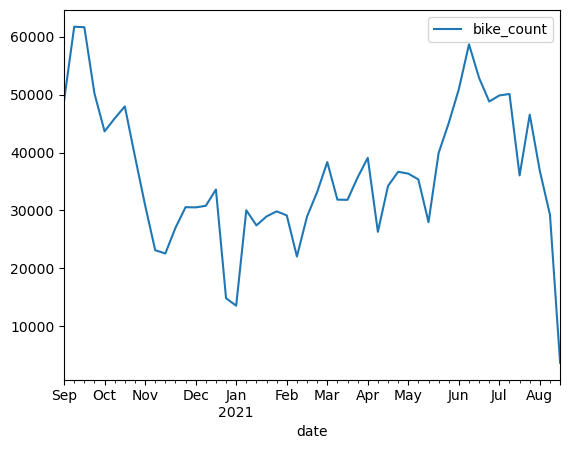

In [133]:
mask = train["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"

train[mask].groupby(pd.Grouper(freq="1w", key="date"))[["bike_count"]].sum().plot()

<AxesSubplot:xlabel='date'>

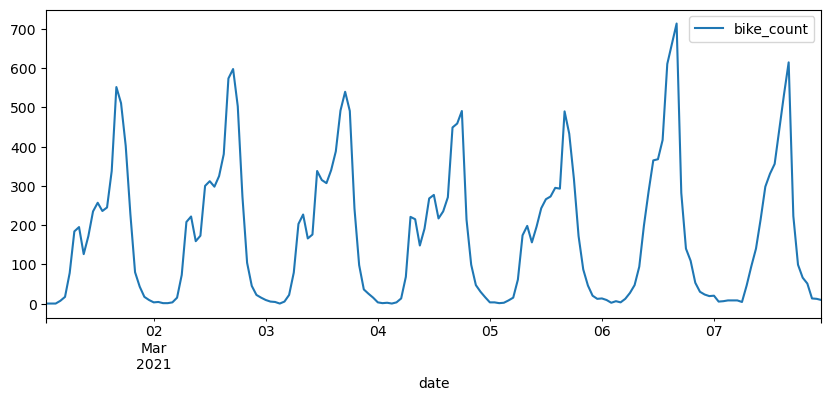

In [134]:
fig, ax = plt.subplots(figsize=(10, 4))

mask = (
    (train["counter_name"] == "Totem 64 Rue de Rivoli O-E")
    & (train["date"] > pd.to_datetime("2021/03/01"))
    & (train["date"] < pd.to_datetime("2021/03/08"))
)

train[mask].plot(x="date", y="bike_count", ax=ax)

# CLOSER LOOK AT CONFINEMENT

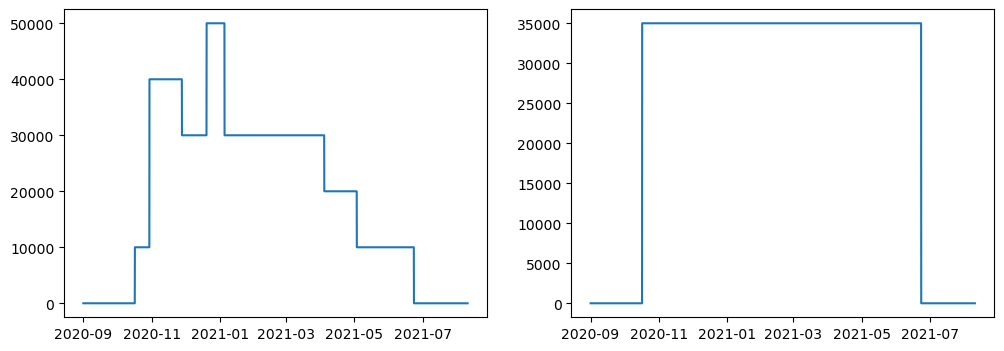

In [203]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(X_train.date, X_train.Intensev1*10000)
ax[1].plot(X_train.date, X_train.conf*35000)


In [184]:
avg_weekly = train.groupby(pd.Grouper(freq="1w", key="date"))[["bike_count"]].sum()

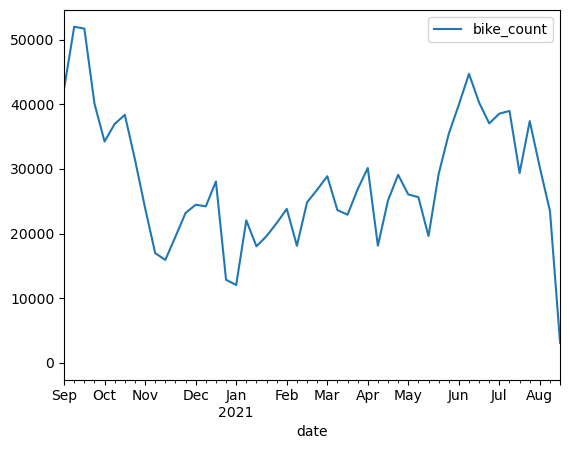

In [190]:
mask = train["counter_name"] == "Totem 64 Rue de Rivoli O-E"

train[mask].groupby(pd.Grouper(freq="1w", key="date"))[["bike_count"]].sum().plot()

#conf.conf.plot()

# Phases 1 2 3

In [136]:
avg_count = train.groupby(pd.Grouper(freq="1h", key="date"))[["bike_count"]].mean()

In [137]:
avg_count.rename(columns={'bike_count': 'Avg_bike_count'}, inplace=True)

In [138]:
train = pd.merge_asof(
        train, avg_count, on="date"
    )

# Phase 1 on AVG bike_count

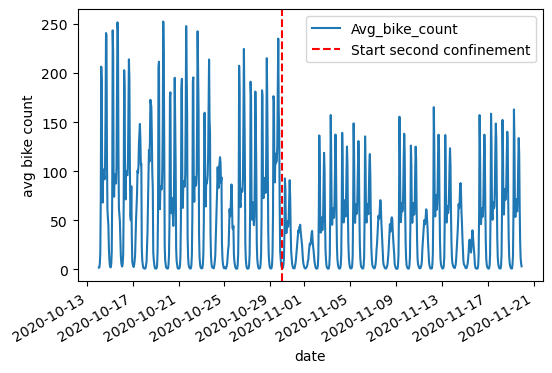

In [139]:
fig, ax = plt.subplots(figsize=(6, 4))

mask = ((train["date"] > pd.to_datetime("2020/10/14"))
    & (train["date"] < pd.to_datetime("2020/11/20"))
)


train[mask].plot(x="date", y="Avg_bike_count", ax=ax)
plt.ylabel('avg bike count')
plt.axvline(x="2020/10/30", label="Start second confinement", color="r", linestyle="dashed") #4
#plt.axvline(x="2020/11/27", label="start phase 4", color="y", linestyle="dashed") #3

plt.legend()

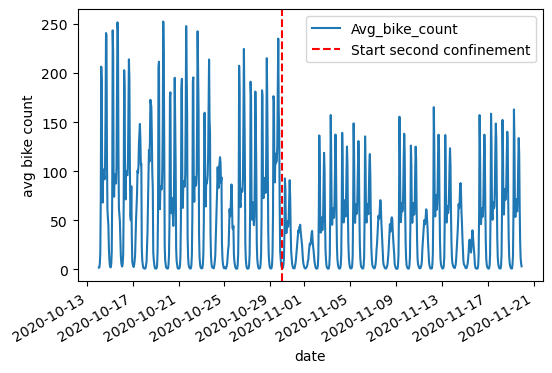

In [140]:
fig, ax = plt.subplots(figsize=(6, 4))

mask = ((train["date"] > pd.to_datetime("2020/10/14"))
    & (train["date"] < pd.to_datetime("2020/11/20"))
)


train[mask].plot(x="date", y="Avg_bike_count", ax=ax)
plt.ylabel('avg bike count')
plt.axvline(x="2020/10/30", label="Start second confinement", color="r", linestyle="dashed") #4
#plt.axvline(x="2020/11/27", label="start phase 4", color="y", linestyle="dashed") #3

plt.legend()

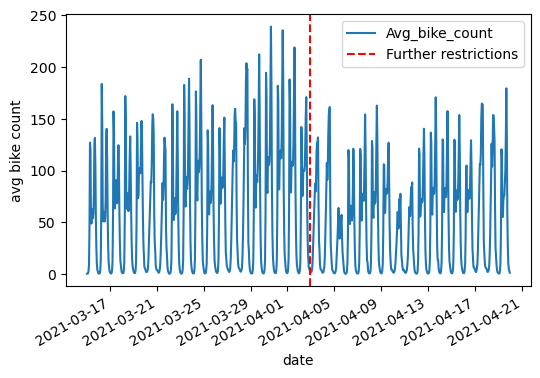

In [141]:
fig, ax = plt.subplots(figsize=(6, 4))

mask = ((train["date"] > pd.to_datetime("2021/03/15"))
    & (train["date"] < pd.to_datetime("2021/04/20"))
)


train[mask].plot(x="date", y="Avg_bike_count", ax=ax)
plt.ylabel('avg bike count')
plt.axvline(x="2021/04/03", label="Further restrictions", color="r", linestyle="dashed") #4
#plt.axvline(x="2020/11/27", label="start phase 4", color="y", linestyle="dashed") #3

plt.legend()

# Phases 3 4 5

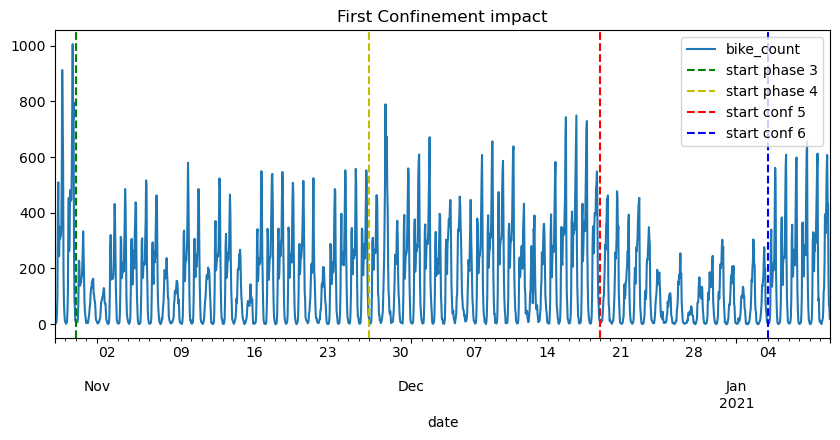

In [142]:
fig, ax = plt.subplots(figsize=(10, 4))

mask = (
    (train["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (train["date"] > pd.to_datetime("2020/10/28"))
    & (train["date"] < pd.to_datetime("2021/01/10"))
)



train[mask].plot(x="date", y="bike_count", ax=ax)
plt.axvline(x="2020/10/30", label="start phase 3", color="g", linestyle="dashed") #4
plt.axvline(x="2020/11/27", label="start phase 4", color="y", linestyle="dashed") #3
plt.axvline(x="2020/12/19", label="start conf 5", color="r", linestyle="dashed") #5
plt.axvline(x="2021/01/04", label="start conf 6", color="b", linestyle="dashed") 
plt.title('First Confinement impact')
plt.legend()

# Phases 6 7

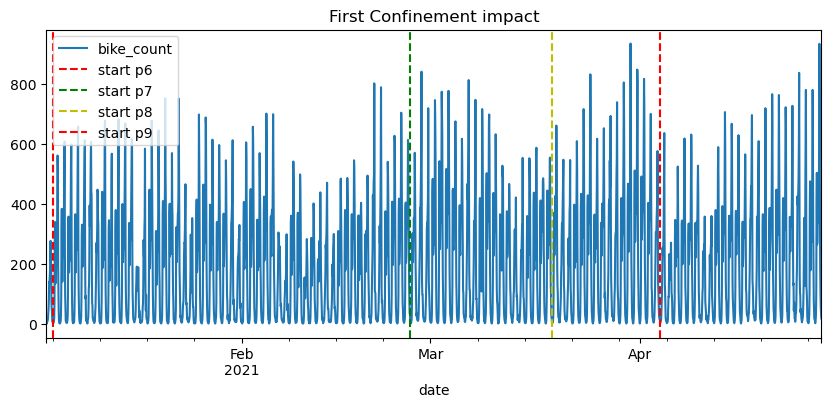

In [143]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 4))

mask = (
    (train["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (train["date"] > pd.to_datetime("2021/01/03"))
    & (train["date"] < pd.to_datetime("2021/04/28"))
)



train[mask].plot(x="date", y="bike_count", ax=ax)
#plt.axvline(x="2020/10/30", label="start phase 3", color="b", linestyle="dashed")
#plt.axvline(x="2020/11/27", label="start phase 4", color="g", linestyle="dashed")
#plt.axvline(x="2020/12/19", label="start conf 5", color="r", linestyle="dashed")

plt.axvline(x="2021/01/04", label="start p6", color="r", linestyle="dashed") #3
plt.axvline(x="2021/02/26", label="start p7", color="g", linestyle="dashed") #3
plt.axvline(x="2021/03/19", label="start p8", color="y", linestyle="dashed") #3
plt.axvline(x="2021/04/04", label="start p9", color="r", linestyle="dashed") #2
plt.title('First Confinement impact')
plt.legend()
plt.show()

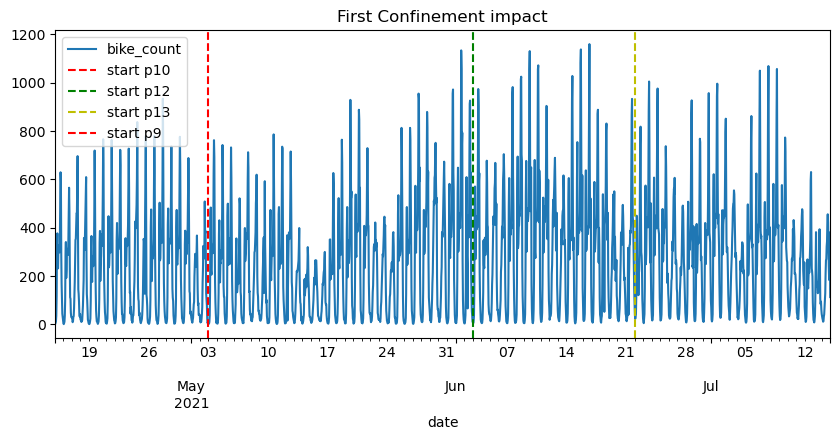

In [144]:
fig, ax = plt.subplots(figsize=(10, 4))

mask = (
    (train["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (train["date"] > pd.to_datetime("2021/04/15"))
    & (train["date"] < pd.to_datetime("2021/07/15"))
)



train[mask].plot(x="date", y="bike_count", ax=ax)
#plt.axvline(x="2020/10/30", label="start phase 3", color="b", linestyle="dashed")
#plt.axvline(x="2020/11/27", label="start phase 4", color="g", linestyle="dashed")
#plt.axvline(x="2020/12/19", label="start conf 5", color="r", linestyle="dashed")

plt.axvline(x="2021/05/03", label="start p10", color="r", linestyle="dashed") #1
plt.axvline(x="2021/06/03", label="start p12", color="g", linestyle="dashed") #1
plt.axvline(x="2021/06/22", label="start p13", color="y", linestyle="dashed") #1
plt.axvline(x="2021/04/04", label="start p9", color="r", linestyle="dashed") #2
plt.title('First Confinement impact')
plt.legend()

Text(0.5, 1.0, 'First Confinement impact')

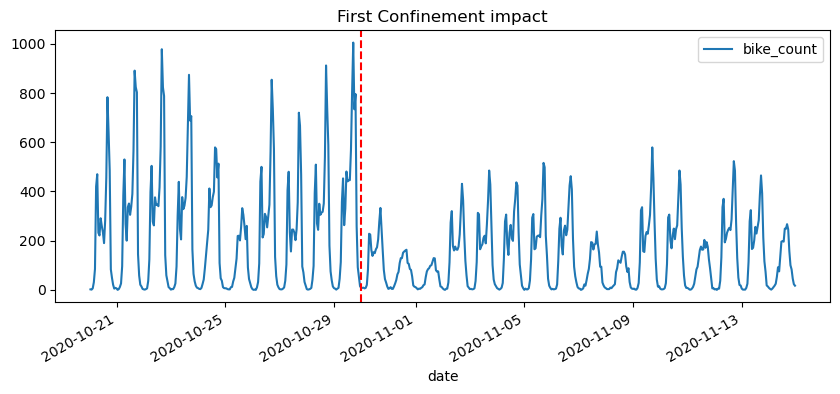

In [145]:
fig, ax = plt.subplots(figsize=(10, 4))

mask = (
    (train["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (train["date"] > pd.to_datetime("2020/10/20"))
    & (train["date"] < pd.to_datetime("2020/11/15"))
)

train[mask].plot(x="date", y="bike_count", ax=ax)
plt.axvline(x="2020/10/30", label="start conf 1", color="r", linestyle="dashed")
plt.title('First Confinement impact')

# Phase 5

The hourly pattern has a clear variation between work days and weekends (7 and 8 March 2021).

If we look at the distribution of the target variable it skewed and non normal, 

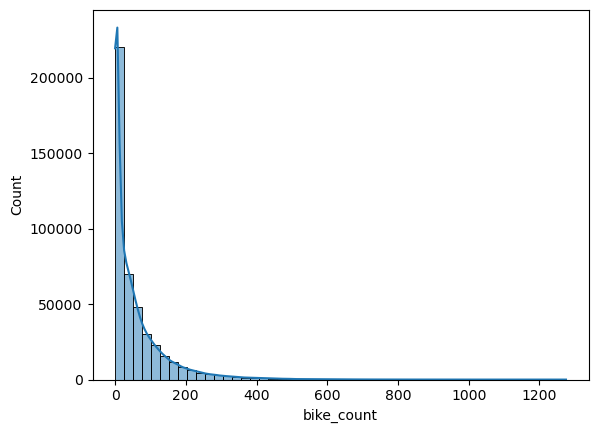

In [146]:
import seaborn as sns


ax = sns.histplot(train, x="bike_count", kde=True, bins=50)

Least square loss would not be appropriate to model it since it is designed for normal error distributions. One way to precede would be to transform the variable with a logarithmic transformation,
```py
data['log_bike_count'] = np.log(1 + data['bike_count'])
```

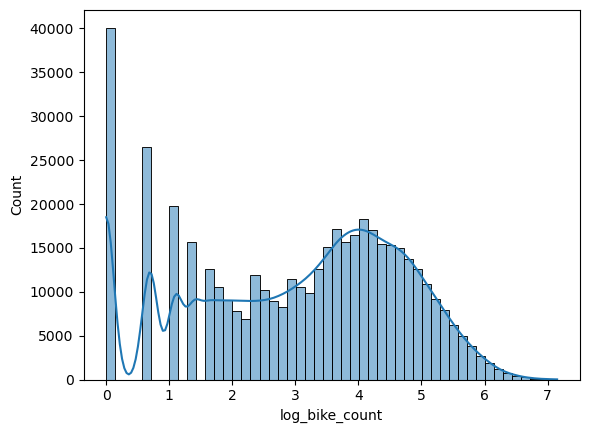

In [147]:
ax = sns.histplot(train, x="log_bike_count", kde=True, bins=50)

which has a more pronounced central mode, but is still non symmetric. In the following, **we use `log_bike_count` as the target variable** as otherwise `bike_count` ranges over 3 orders of magnitude and least square loss would be dominated by the few large values. 

## Feature extraction

To account for the temporal aspects of the data, we cannot input the `date` field directly into the model. Instead we extract the features on different time-scales from the `date` field, 

In [148]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour
    #X.loc[:, "sinhour"] = np.sin((X["hour"]*0.9/math.pi)-3*math.pi/4)

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [149]:
train["date"].tail()

455158   2021-08-09 23:00:00
455159   2021-08-09 23:00:00
455160   2021-08-09 23:00:00
455161   2021-08-09 23:00:00
455162   2021-08-09 23:00:00
Name: date, dtype: datetime64[ns]

In [150]:
_encode_dates(train[["date"]].head())

,year,month,day,weekday,hour
0,2020,9,1,1,1
1,2020,9,1,1,1
2,2020,9,1,1,1
3,2020,9,1,1,1
4,2020,9,1,1,1


To use this function with scikit-learn estimators we wrap it with [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html),

In [151]:
from sklearn.preprocessing import FunctionTransformer

date_encoder = FunctionTransformer(_encode_dates, validate=False)
date_encoder.fit_transform(train[["date"]]).head()

,year,month,day,weekday,hour
0,2020,9,1,1,1
1,2020,9,1,1,1
2,2020,9,1,1,1
3,2020,9,1,1,1
4,2020,9,1,1,1


Since it is unlikely that, for instance, that `hour` is linearly correlated with the target variable, we would need to additionally encode categorical features for linear models. This is classically done with [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), though other encoding strategies exist.

In [152]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)

enc.fit_transform(_encode_dates(train[["date"]])[["hour"]].tail())

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]])

## Import the data

In [153]:
ext_intense16 = pd.read_csv('ext_data/ext_intense16.csv')
ext_intense16.drop('Unnamed: 0', axis=1,inplace=True)
ext_intense16["date"] = pd.to_datetime(ext_intense16["date"], format = "%Y-%m-%d %H:%M:%S")
ext_intense16

,date,conf,ww_mix,pmer,ff,t,u,vv,ww,nbas,...,etat_sol,rr1,rr3,hourly,Intensev1,Intensev2,vacances_zone_c,bank_days,strike_rate,Vehicules
0,2020-09-01 00:00:00,0,1.0,102050,1.6,12.6,81,30000,1,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0.0,81.338753
1,2020-09-01 01:00:00,0,0.0,102050,1.6,12.6,81,30000,1,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0.0,81.338753
2,2020-09-01 02:00:00,0,0.0,102050,1.6,12.6,81,30000,1,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0.0,81.338753
3,2020-09-01 03:00:00,0,2.0,101990,1.1,10.8,88,25000,2,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0.0,81.338753
4,2020-09-01 04:00:00,0,0.0,101990,1.1,10.8,88,25000,2,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0.0,81.338753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9884,2021-10-17 20:00:00,0,0.0,102050,2.2,12.5,68,25000,3,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0.0,66.418217
9885,2021-10-17 21:00:00,0,1.0,102120,1.1,9.6,82,25000,1,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0.0,66.418217
9886,2021-10-17 22:00:00,0,0.0,102120,1.1,9.6,82,25000,1,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0.0,66.418217
9887,2021-10-17 23:00:00,0,0.0,102120,1.1,9.6,82,25000,1,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0.0,66.418217


In [154]:
import problem

X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

In [155]:
X_train.shape

(455163, 10)

In [156]:
X_train = pd.merge_asof(
        X_train, ext_intense16, on="date"
)

In [157]:
X_train.shape

(455163, 31)

In [158]:
X_train.drop(columns=X_train.columns
                    .intersection(['counter_id','site_id','coordinates','bike_count',
                                 'counter_technical_id','log_bike_count','latitude','longitude']),
                    inplace=True)

In [159]:
X_test = pd.merge_asof(
        X_test, ext_intense16, on="date"
    )

X_test.drop(columns=X_test.columns
                    .intersection(['counter_id','site_id','coordinates','bike_count',
                                 'counter_technical_id','log_bike_count','latitude','longitude']),
                    inplace=True)


In [171]:
X_train.Intensev1

0         0
1         0
2         0
3         0
4         0
         ..
455158    0
455159    0
455160    0
455161    0
455162    0
Name: Intensev1, Length: 455163, dtype: int64

and

Where `y` contains the `log_bike_count` variable. 

The test set is in the future as compared to the train set,

In [160]:
print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Test: n_samples={X_test.shape[0]},  {X_test["date"].min()} to {X_test["date"].max()}'
)

Train: n_samples=455163,  2020-09-01 01:00:00 to 2021-08-09 23:00:00
Test: n_samples=41608,  2021-08-10 01:00:00 to 2021-09-09 23:00:00


In [161]:
_encode_dates(X_train[["date"]]).columns.tolist()

['year', 'month', 'day', 'weekday', 'hour']

In [162]:
X_train.columns

Index(['counter_name', 'site_name', 'date', 'counter_installation_date',
       'conf', 'ww_mix', 'pmer', 'ff', 't', 'u', 'vv', 'ww', 'nbas', 'pres',
       'raf10', 'etat_sol', 'rr1', 'rr3', 'hourly', 'Intensev1', 'Intensev2',
       'vacances_zone_c', 'bank_days', 'strike_rate', 'Vehicules'],
      dtype='object')

# XGB

In [163]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")


categorical_cols0 = ["counter_name", "site_name","conf"]
categorical_cols1 = ["counter_name", "site_name","conf","hourly"]
categorical_cols = ["counter_name", "site_name", "etat_sol", "conf", "hourly","ww"]

numerical_cols1 = ['rr1']


preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols)
        ,("num", 'passthrough', numerical_cols1) 
        
    ]
)

xreg = xgb.XGBRegressor(max_depth=12, objective='reg:squarederror', learning_rate=0.2, n_estimators=110)
regressor = Ridge()

pipe = make_pipeline(date_encoder, 
                     preprocessor,
                     xreg)

pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x0000027F854C1550>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'etat_sol', 'conf', 'hourly...
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='', learning_rate=0.2,
  

We then evaluate this model with the RMSE metric,

In [164]:

from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.3f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.3f}"
)

Train set, RMSE=0.338
Test set, RMSE=0.411


# XGB 2

In [165]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
import time

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")


categorical_cols = ["counter_name", "site_name", "etat_sol", "ww", "conf", "hourly","vacances_zone_c"]

numerical_cols = ['rr1','Intensev1','Vehicules','raf10',"u",'pmer', 'ff', 't', 'u', 'vv']



preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols)
        ,("num", 'passthrough', numerical_cols) 
        
    ]
)

xreg = xgb.XGBRegressor(max_depth=12, objective='reg:squarederror', learning_rate=0.2, n_estimators=110)
regressor = Ridge()

pipe = make_pipeline(date_encoder, 
                     preprocessor,
                     xreg)

start1 = time.time()
pipe.fit(X_train, y_train)
end1 = time.time()
print(end1 - start1)

21.760658502578735


In [166]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.3f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.3f}"
)

Train set, RMSE=0.305
Test set, RMSE=0.515


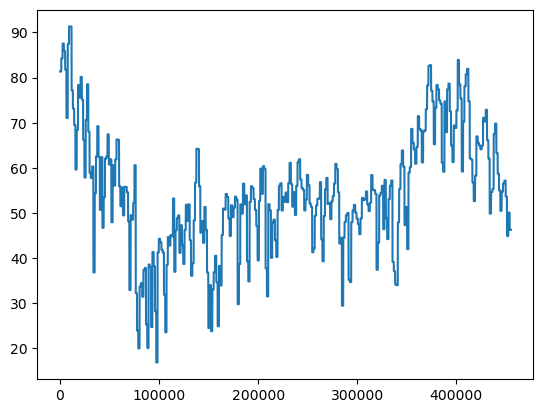

In [167]:
plt.plot(X_train['Vehicules'])

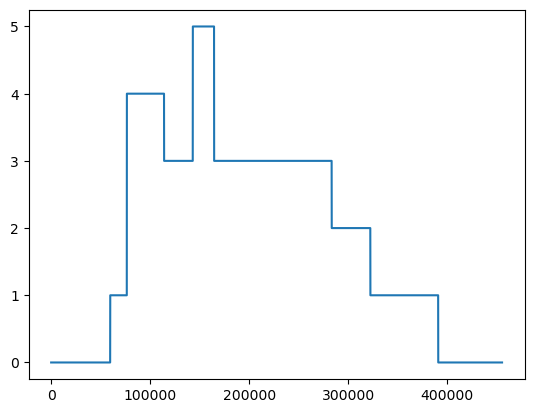

In [168]:
plt.plot(X_train['Intensev1'])

# NN 6 

In [204]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin


date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_cols = ["counter_name", "site_name", "etat_sol", "ww", "conf", "hourly","vacances_zone_c"]

numerical_cols = ['rr1','Intensev1','Vehicules','raf10',"u",'pmer', 'ff', 't', 'u', 'vv']


preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols)
        ,("num",StandardScaler(), numerical_cols) 
        
    ]
)


class MyModel(keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = layers.Dense(25)
        self.dense2 = layers.Dense(15)
        #self.dense3 = layers.Dense(5)
        self.dense4 = layers.Dense(1)
    
    def call(self, input_tensor):
        x = tf.nn.relu(self.dense1(input_tensor))
        x = tf.nn.relu(self.dense2(x))
        #x = tf.nn.relu(self.dense3(x))
        x = tf.nn.relu(self.dense4(x))
        return tf.reshape(x, [-1])

NN = MyModel()
NN.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()])



pipe = make_pipeline(date_encoder, preprocessor, NN)
pipe.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/my_model_8/dense_24/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/my_model_8/dense_24/embedding_lookup_sparse/Reshape:0", shape=(None, 25), dtype=float32), dense_shape=Tensor("gradient_tape/my_model_8/dense_24/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


14224/14224 [==============================] - 33s 2ms/step - loss: 0.3384 - root_mean_squared_error: 0.5817


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x0000027F854C1550>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'etat_sol', 'ww', 'conf',
                                                   'hourly',
                                                   'vacances_zone_c']),
                                                 ('num', StandardScaler(),
                       

In [205]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.3f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.3f}"
)

14224/14224 [==============================] - 21s 1ms/step
Train set, RMSE=0.453
1301/1301 [==============================] - 2s 1ms/step
Test set, RMSE=0.477


In [206]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin


date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_cols = ["counter_name", "site_name", "etat_sol", "ww", "conf", "hourly","vacances_zone_c","ww_mix","bank_days"]

numerical_cols = ['rr1','Intensev1','Vehicules','raf10',"u",'pmer', 'ff', 't', 'u', 'vv', "nbas","rr3","pres"]


preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols)
        ,("num",StandardScaler(), numerical_cols) 
        
    ]
)


class MyModel(keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = layers.Dense(25)
        self.dense2 = layers.Dense(15)
        #self.dense3 = layers.Dense(5)
        self.dense4 = layers.Dense(1)
    
    def call(self, input_tensor):
        x = tf.nn.relu(self.dense1(input_tensor))
        x = tf.nn.relu(self.dense2(x))
        #x = tf.nn.relu(self.dense3(x))
        x = tf.nn.relu(self.dense4(x))
        return tf.reshape(x, [-1])

NN = MyModel()
NN.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()])

      

pipe = make_pipeline(date_encoder, preprocessor, NN)
pipe.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/my_model_9/dense_27/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/my_model_9/dense_27/embedding_lookup_sparse/Reshape:0", shape=(None, 25), dtype=float32), dense_shape=Tensor("gradient_tape/my_model_9/dense_27/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


14224/14224 [==============================] - 33s 2ms/step - loss: 0.3332 - root_mean_squared_error: 0.5772


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x0000027F854C1550>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'etat_sol', 'ww', 'conf',
                                                   'hourly', 'vacances_zone_c',
                                                   'ww_mix', 'bank_days']),
                                                 ('num', StandardScaler(),


In [207]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.3f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.3f}"
)

14224/14224 [==============================] - 22s 2ms/step
Train set, RMSE=0.453
1301/1301 [==============================] - 2s 2ms/step
Test set, RMSE=0.471


# Correlation test for Vehicule Variable

In [ ]:
X_train_trunc = X_train[X_train.date < pd.to_datetime("2020/10/21")]

In [ ]:
data_trunc = pd.concat(([X_train_trunc, pd.Series(xbikes1)]), axis=1)
log_y_trunc = data_trunc.groupby(pd.Grouper(freq="1d", key="date"))[[0]].mean()
x_trunc = data_trunc.groupby(pd.Grouper(freq="1d", key="date"))[['Vehicules']].mean()

In [ ]:
data  = pd.concat(([X_train, pd.Series(y_train)]), axis=1)
x = data.groupby(pd.Grouper(freq="1d", key="date"))[['Vehicules']].mean()
log_y = data.groupby(pd.Grouper(freq="1d", key="date"))[[0]].mean()

In [ ]:
plt.scatter(x_trunc, log_y_trunc)

In [ ]:
plt.scatter(x, log_y)

The model doesn't have enough capacity to generalize on the train set, since we have lots of data with relatively few parameters. However it happened to work somewhat better on the test set. We can compare these results with the baseline predicting the mean value,

In [ ]:
print("Baseline mean prediction.")
print(
    f"Train set, RMSE={mean_squared_error(y_train, np.full(y_train.shape, y_train.mean()), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, np.full(y_test.shape, y_test.mean()), squared=False):.2f}"
)

which illustrates that we are performing better than the baseline.

Let's visualize the predictions for one of the stations,

In [ ]:
mask = (
    (X_test["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_test["date"] > pd.to_datetime("2021/09/01"))
    & (X_test["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_test[mask])) - 1

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")

So we start to see the daily trend, and some of the week day differences are accounted for, however we still miss the details and the spikes in the evening are under-estimated.

A useful way to visualize the error is to plot `y_pred` as a function of `y_true`,

In [ ]:
fig, ax = plt.subplots()

df_viz = pd.DataFrame({"y_true": y_test, "y_pred": pipe.predict(X_test)}).sample(
    10000, random_state=0
)

df_viz.plot.scatter(x="y_true", y="y_pred", s=8, alpha=0.1, ax=ax)

It is recommended to use cross-validation for hyper-parameter tuning with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or more reliable model evaluation with [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score). In this case, because we want the test data to always be in the future as compared to the train data, we can use [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html),

<img src="https://i.stack.imgur.com/Q37Bn.png" />

The disadvantage, is that we can either have the training set size be different for each fold which is not ideal for hyper-parameter tuning (current figure), or have constant sized small training set which is also not ideal given the data periodicity. This explains that generally we will have worse cross-validation scores than test scores, 

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")